<a href="https://colab.research.google.com/github/tmorshed/dbs_cep/blob/master/cep_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing cortical evoked potentials (cEPs) in STN-DBS
#### by Taha Morshedzadeh. **Krembil Research Institute, UHN. Toronto, Canada**

*This work is done as a part of the HMB496 "Independent Project in Human Biology" i.e. undergraduate thesis at the University of Toronto during Fall-Winter semesters of the 2019-20 year.*




In this Jupyter, we will try to estimate the cortical evoked potentials using EEG as a result of Deep Brain Stimulation in the Subthalamic Nucleus (STN). We will use the package `mne` from the Martinos Centre found at [this link](https://mne.tools). This package automatically sets matplotlib to `Qt` but since we are on Colab and it does not yet support `Qt`, we make it `inline` so that it appears as any other normal output in the notebook below the code snippet.


![MNE](https://mne.tools/stable/_static/mne_logo.png)

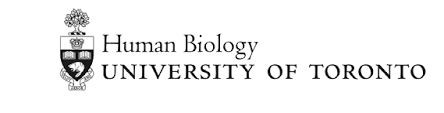


In [0]:
!pip install mne

from google.colab import drive
drive.mount('/content/drive')

### a) import packages and files:

In [0]:
  #import os
    
%reset -sf

import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy.signal as sg
from datetime import datetime
%matplotlib inline

In [0]:
raw = mne.io.read_raw_cnt(r"/content/drive/My Drive/research/nsbspl/data/130Hz_STN_OFF_LeftSTIM.cnt", preload=False)
#preload=True makes it load to RAM as well. Normally, it only loads the symlinks to the RAM and the data stays in the local storage

In [0]:
##Choose channel to analyze                                                     #Please input the desired channel name
ch_choice = ['L2']
#Choose the times below. We will crop the file in this  window.
time_secs = raw.times
start_stop_seconds = np.array([time_secs[0], 2])                                #Please select start and end crop times in seconds


##Import metadata to internal variables
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)
sampling_rate= raw.info['sfreq']
dt=1/sampling_rate

#finds the index for the chosen channel
ranger=np.arange(1,n_chan);
for i in ranger:
  if ch_names[i]==ch_choice[0]:
       index_channel=i
  else:
       pass

## Print some metadata
print('the imported data object has {} time samples and {} channels.'
''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print()  # insert a blank line in the output
print('sampling frequency is {}'.format(sampling_rate, 'Hz'))           
print('MISC INFO: {}'.format(raw.info['description'], '\n')) #misc  info

print(raw.info)
print() #adding an extra row 
print() 
print()
print()

print('The sensor locations on the cranium:')
raw.plot_sensors(show_names=True)
print('The sensor locations in 3D:')
raw.plot_sensors('3d')

In [0]:
#Cropping the file based on the times provided in cell4, line5.
raw_select = raw.copy().load_data()
raw_select.crop(tmin=start_stop_seconds[0], tmax=start_stop_seconds[1], include_tmax=True);
raw_select.pick_channels(ch_choice);
#start_sample, stop_sample = (start_stop_seconds * sampling_rate).astype(int)
times=np.arange(start_stop_seconds[0],start_stop_seconds[1],dt)

#extracting some internal variables from above input
duration_selection = start_stop_seconds[1]-start_stop_seconds[0]
start_sample, stop_sample = (start_stop_seconds * sampling_rate).astype(int)
times=np.arange(start_stop_seconds[0],start_stop_seconds[1],dt)
lsel=len(times)
times=times.reshape(1,lsel)

#printing some metadata
print('We will use the timewindow of {} to {} seconds.'.format(start_stop_seconds[0],start_stop_seconds[1]))
print('this is equal to {} milliseconds in length'.format(duration_selection*1000))
print('this is equal to {} datapoints in length'.format(lsel))

In [0]:
#imports the selected window to a NumPy Array
raw_selection = list(raw[index_channel, start_sample:stop_sample]);
x = raw_selection[1].reshape(lsel,);
y = raw_selection[0].T;
y = np.mean(y) - y
y = y.reshape(lsel,)
#print('Quality control:')
#print(x.shape)
#print(y.shape)


fig = plt.figure();

if duration_selection <= 10:
  figwid = duration_selection*10
else:
    figwid=100

figwid=duration_selection*10;                                                   #select the width of the figures. For durations more than 10 seconds, limit it to 100
axes=fig.add_axes([0, 0, figwid, 1]);
axes.plot(x, y, c='k');
axes.set_facecolor('white')
axes.set_title('imported time window')
axes.set_ylabel('LFP (mV), mean = 0')
axes.set_xlabel('time (seconds)')
axes.autoscale_view(tight=True)

## Find the peaks:

In [0]:
amp_max=max(y)
amp_th=amp_max/2
print(amp_max)
print(amp_th)

pkfinder=sg.find_peaks(y, height=(amp_th))

indx_pks, pks = pkfinder[0]*dt+start_stop_seconds[0], pkfinder[1]['peak_heights']
lstim=len(indx_pks)

# x must be the indx_pks array when time is defined in seconds
def stim_avg_freq(x):
  x1 = np.insert(x,0,0)
  x1 = np.delete(x1,-1)
  dist = x - x1
  return 1/np.mean(dist)

raw_seletion_stim_freq=stim_avg_freq(indx_pks)

print()
print('Average stimulation frequency in the imported window is {} Hz'.format(
    raw_selection_stim_freq
)

#print(indx_pks.shape) #Quality Check
#print(pks.shape)
#print()
#print(indx_pks)
#print()
#print(pks)


##Change events into MNE format, will be stored in i, for possible use:

#i = pkfinder[0].reshape(1,len(indx_pks)) #i = np.append(pkfinder[0].reshape(len(indx_pks),1), np.zeros((len(indx_pks),2), int), axis=1)
#print(i.shape)


fig = plt.figure();
#plt.savefig(fname='/content/drive/My Drive/research/nsbspl/figures/cep/{}_selected_window.png'.format(datetime.now()))
axes=fig.add_axes([1, 1, figwid, 1]);
axes.plot(x, y, c='k');
axes.scatter(indx_pks, pks, marker='x', c='maroon')
axes.set_title('detected peaks')
axes.set_facecolor('white')
axes.set_ylabel('LFP in mV, mean = 0')
axes.set_xlabel('time, in seconds')
axes.autoscale_view(tight=True, scalex=True, scaley=True)

In [0]:
_indx_pks1 = np.insert(indx_pks,0,0)
indx_pks1 = np.delete(indx_pks1,-1)
spike_distances = indx_pks1 - indx_pks
print(1/np.mean(spike_distances))

In [0]:
spike_distances = indx_pks1 - indx_pks
print(1/np.mean(spike_distances))

In [0]:
##Making a stim channel out of the found peaks

stim_data = np.zeros((1, lsel+1))[0]
print(stim_data)

for j in range(1,lstim):
  stim_data[pkfinder[0][j]] = pks[j]
stim_data=stim_data.reshape(1,lsel+1)

print() #1-line gap
print(stim_data.shape)   # Quality Control
print(len(indx_pks))    # Quality Control
print(len(pkfinder[0])) # Quality Control

stim_info = mne.create_info(['STI'], sfreq=sampling_rate)
stim_raw = mne.io.RawArray(stim_data, stim_info)
raw_select.add_channels([stim_raw], force_update_info=True)
raw_select.set_channel_types({'STI':'stim'})

In [0]:
events = mne.find_events(raw_select, stim_channel='STI')
print(events)

In [0]:
del events